In [1]:
from FSC import *
import mrcfile
import time
import pandas as pd
import os
from resolution_measure_mrc import *
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # Formatting for editable pdf text
matplotlib.rcParams['font.sans-serif']=['Arial']

figs_dir = '/Users/atk42/OneDrive - Yale University/Lab/Projects/TEM_tomo/fig_panels/'
thick_pal={'1000nm':'#fe4a49','750nm':'#2ab7ca','500nm':'#fed766'}
thick_pal={'1000nm':'#0077BB','750nm':'#009988','500nm':'#EE7733'}
#https://personal.sron.nl/~pault/
def import_fsc_results(output_dir, tomo_lst, num_angs, max_angs, constant_density = False):
    df = pd.read_csv(tomo_lst)
    all_fsc = dict()
    #pd.DataFrame()
    for ref in ['a','b']:
        all_fsc[ref] = pd.DataFrame()
        for index,row in df.iterrows():
            proj = 'microscopy_%i' % int(row['MPID'])
            tomo = row['Tomogram']
            thickness = row['Thickness']
            pixel_size = row['Pixel Size bin 4 (nm)']
        
            for idx,num_ang in enumerate(num_angs):
                if constant_density:
                    max_angs_load = [max_angs[idx]]
                else:
                    max_angs_load = max_angs
                for max_ang in max_angs_load:
                    if num_ang == 121 and max_ang == 10:
                        continue
                    ofn = os.sep.join([output_dir, 'FSC3D_ref%s_%s_%s_%i-limited[%.1f_-%.1f].csv' % (ref, thickness, tomo,num_ang,max_ang,max_ang)])
                    fsc_df = pd.read_csv(ofn,header=None,names = ['z','x','y','res','mean','corr'])
                    fsc_df['thickness'] = thickness
                    fsc_df['pixel_size'] = float(pixel_size)
                    fsc_df['name'] = tomo
                    fsc_df['num_ang'] = int(num_ang)
                    fsc_df['max_ang'] = int(max_ang)
                    fsc_df['plane'] = '3d'
                    #fsc_df['fsc_resolution'] = [float(i[0:6]) for i in fsc_df['res'].values]
                    fsc_df['fsc_resolution'] = [float(i) for i in fsc_df['res'].values]
                    fsc_df['correlation'] = [float(i) for i in fsc_df['corr'].values]
                    all_fsc[ref] = pd.concat([all_fsc[ref], fsc_df])
    return all_fsc

def average_dfs(df1, df2, exclude_cols = None):

    # Identifying numeric columns
    numeric_cols = df1.select_dtypes(include=[np.number]).columns

    # Averaging numeric columns
    average_df = (df1[numeric_cols] + df2[numeric_cols]) / 2

    # Handling non-numeric columns
    for col in df1.columns:
        if col not in exclude_cols:
            if col not in numeric_cols:
                if (df1[col] == df2[col]).all():
                    average_df[col] = df1[col]
                else:
                    raise ValueError(f"Non-matching values found in column {col}")
    return average_df

In [2]:
# Load FSC results from csv outputs from dtilt_ref_calc_tomo_FSCs.py
num_angs = [121, 33, 21, 17, 11, 5]
max_angs = [10,20,30,40,50,60]

tomo_lst = 'tomo_lists/tomograms_lst - double_tilt_tomos_3.3k.csv'
output_dir_3k = 'results/240523_3.3k_4x'
fscs_3k= import_fsc_results(output_dir_3k, tomo_lst, num_angs, max_angs)
# Average "a" and "b" reference calculations (to make symmetrical)
all_fsc_3k = average_dfs(fscs_3k['a'],fscs_3k['b'], exclude_cols=['res','corr'])
# Include thickness 0.5, .75 and 1 um
all_fsc_3k = all_fsc_3k[all_fsc_3k['thickness'].isin(['500nm','750nm','1000nm'])]

tomo_lst_11k = 'tomo_lists/tomograms_lst - double_tilt_tomos_11k.csv'
output_dir_11k = 'results/240514_11k_4x'
fscs_11k= import_fsc_results(output_dir_11k, tomo_lst_11k, num_angs, max_angs)
# Average "a" and "b" reference calculations (to make symmetrical)
all_fsc_11k = average_dfs(fscs_11k['a'],fscs_11k['b'], exclude_cols=['res','corr'])
# Include thickness 0.5, .75 and 1 um
all_fsc_11k = all_fsc_11k[all_fsc_11k['thickness'].isin(['500nm','750nm','1000nm'])]

500nm: 11.8 ± 1.3 nm
750nm: 12.7 ± 0.9 nm
1000nm: 14.8 ± 0.7 nm


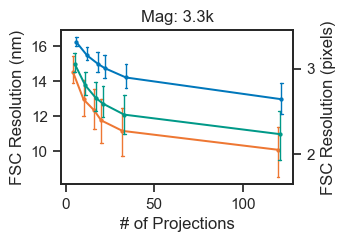

In [43]:
# Main Plot for FSC res vs # projections 
# Fig. 1e
max_ang = 30
mag = '3.3k'
#mag = '11k'
if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k
my_df = my_df[my_df['max_ang']==max_ang]
pixel_size = my_df['pixel_size'].values[0]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

my_df = my_df[my_df['fsc_resolution']>0] # remove outlier cubes
g = sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='thickness', estimator='mean',
            errorbar=('pi',50), 
            #errorbar = ('ci', 95),
            native_scale=True, dodge = 0.5, palette=thick_pal,
            log_scale = False,  markersize = 2, capsize = .4,
            err_kws={'linewidth':1})

handles, labels = g.get_legend_handles_labels()
order = [2,1,0]
g.legend().remove()
#g.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#         title = 'Thickness', bbox_to_anchor=(-0.3, -.8), loc='lower left',ncol=3)
#g.axhline(y=2*pixel_size, color = 'k', linestyle = '--')
g.set_xlabel('# of Projections')
g.set_ylabel('FSC Resolution (nm)')
g.set_title('Mag: %s' % mag)#, ha='left', x = 0.1)
#g.grid(axis='y', color = 'k', linewidth=0.5)
#g.set_ylim([10,g.get_ylim()[1]])


num_ang = 21
for thickness in my_df.thickness.unique():
    test_df = my_df[my_df.thickness == thickness]
    test_df = test_df[test_df.num_ang == num_ang]
    
    print('%s: %0.1f ± %0.1f nm' % (thickness,np.mean(test_df.fsc_resolution.values),stats.iqr(test_df.fsc_resolution.values)/2))

ax2 = g.twinx()
y1, y2 = g.get_ylim()
ax2.set_ylim(y1/pixel_size, y2/pixel_size)
ax2.set_yticks([2,3])
ax2.set_ylabel('FSC Resolution (pixels)')
#sns.despine()

plt.savefig(figs_dir + 'Fig1e_Numang_FSCres_thickness_3D_%s.pdf' % mag, bbox_inches = 'tight')


1.425
500nm: 4.2 ± 0.07 nm
750nm: 4.4 ± 0.07 nm
1000nm: 4.6 ± 0.04 nm


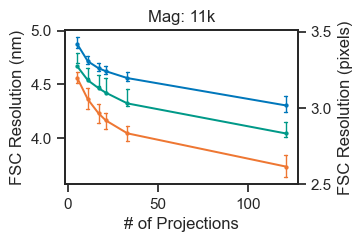

In [60]:
# Main Plot for FSC res vs # projections 
# Fig. 1f
max_ang = 30
mag = '11k'
if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k
my_df = my_df[my_df['max_ang']==max_ang]
pixel_size = my_df['pixel_size'].values[0]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

my_df = my_df[my_df['fsc_resolution']>0] # remove outlier cubes
g = sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='thickness', estimator='mean',
            errorbar=('pi',50), 
            #errorbar = ('ci', 95),
            native_scale=True, dodge = 0, palette=thick_pal,
            log_scale = False,  markersize = 2, capsize = .4,
            err_kws={'linewidth':1})

handles, labels = g.get_legend_handles_labels()
order = [2,1,0]
#g.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
#         title = 'Thickness', bbox_to_anchor=(.5, .7), loc='lower left',ncol=1)
#g.axhline(y=2*pixel_size, color = 'k', linestyle = '--')
g.legend().remove()
g.set_xlabel('# of Projections')
g.set_ylabel('FSC Resolution (nm)')
g.set_title('Mag: %s' % mag)#, ha='left', x = 0.1)
#g.grid(axis='y', color = 'k', linewidth=0.5)
#g.set_ylim([10,g.get_ylim()[1]])

ax2 = g.twinx()
y1, y2 = g.get_ylim()
ax2.set_ylim(y1/pixel_size, y2/pixel_size)
ax2.set_yticks([2.5,3,3.5])
ax2.set_ylabel('FSC Resolution (pixels)')

num_ang = 21
for thickness in my_df.thickness.unique():
    test_df = my_df[my_df.thickness == thickness]
    test_df = test_df[test_df.num_ang == num_ang]
    
    print('%s: %0.1f ± %0.2f nm' % (thickness,np.mean(test_df.fsc_resolution.values),stats.iqr(test_df.fsc_resolution.values)/2))
plt.savefig(figs_dir + 'Fig1f_Numang_FSCres_thickness_3D_%s.pdf' % mag, bbox_inches = 'tight')

4.908


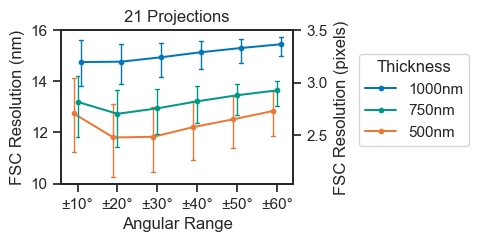

In [74]:
# Compare same number of proj over different ranges
num_ang = 21
theta_labels = ['±%s°' % ang for ang in max_angs]

mag = '3.3k'
if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k

my_df = my_df[my_df['num_ang']==num_ang]
pixel_size = my_df['pixel_size'].values[0]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')
my_df = my_df[my_df['fsc_resolution']>0] # remove outlier cubes

g = sns.pointplot(my_df,x='max_ang', y = 'fsc_resolution', hue='thickness', estimator='median',
            errorbar=('pi',50), native_scale=True, dodge = 0.2, palette=thick_pal,
            log_scale = False,  markersize = 3, capsize = .1,
            err_kws={'linewidth':1})
#g.axhline(y=2*pixel_size, color = 'k', linestyle = '--')
handles, previous_labels = g.get_legend_handles_labels()
order = [2,1,0]
g.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
         title = 'Thickness', bbox_to_anchor=(1.25, 0.2), loc='lower left',ncol=1)
g.set_xlabel('Angular Range')
g.set_xticks(max_angs)
g.set_xticklabels(theta_labels)
g.set_ylabel('FSC Resolution (nm)')
g.set_title('%i Projections' % num_ang)
print(pixel_size)
ax2 = g.twinx()
y1, y2 = g.get_ylim()
ax2.set_ylim(y1/pixel_size, y2/pixel_size)
ax2.set_yticks([2.5,3,3.5])
ax2.set_ylabel('FSC Resolution (pixels)')
#sns.despine()
plt.savefig(figs_dir + 'Fig1g_thetaRange_FSCres_Numang_%i_3D.pdf'%num_angs[0], bbox_inches = 'tight')

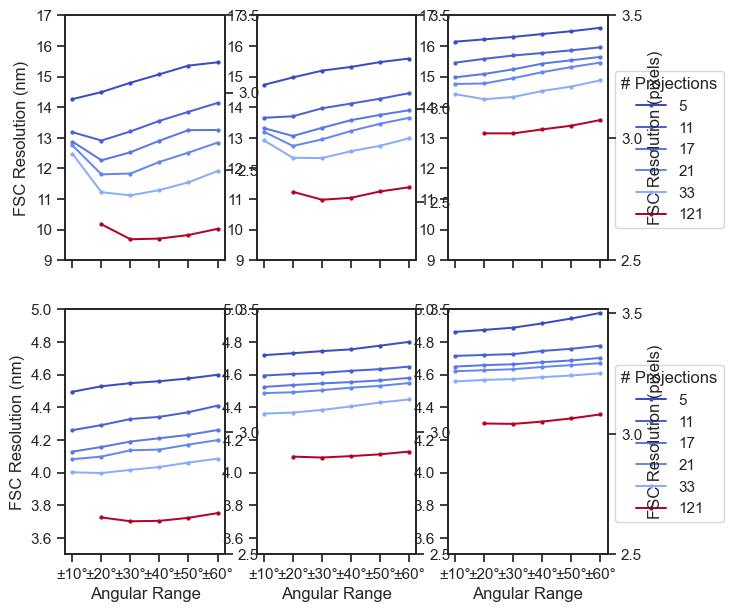

In [90]:
# Full FSC results array
thicknesses = ['500nm','750nm','1000nm']
mags = ['3.3k', '11k']
theta_labels = ['±%s°' % ang for ang in max_angs]


sns.set_theme(rc={'figure.figsize':(7,7),'lines.linewidth':0.8},style = 'ticks')
fig,axs = plt.subplots(len(mags),len(thicknesses))

for (m_idx, mag) in enumerate(mags):
    for (t_idx, thickness) in enumerate(thicknesses):
        if mag == '3.3k':
            my_df = all_fsc_3k
        elif mag == '11k':
            my_df = all_fsc_11k

        my_df = my_df[my_df['thickness']==thickness]
        my_df = my_df[my_df['num_ang'].isin(num_angs)]
        pixel_size = my_df['pixel_size'].values[0]


        my_df.dropna(subset=['fsc_resolution'], inplace=True)
        my_df['num_ang'] = [int(i) for i in my_df['num_ang'].values]
        pixel_size = my_df['pixel_size'].values[0]
        ax = axs[m_idx,t_idx]
        g = sns.pointplot(my_df,x='max_ang', y='fsc_resolution', hue='num_ang', estimator='median',
                    errorbar=None, native_scale=True, dodge = 0, palette='coolwarm',
                    log_scale = False,  markersize = 2, capsize = .2,
                    err_kws={'linewidth':1}, ax = ax)
        handles, previous_labels = g.get_legend_handles_labels()

        ax2 = g.twinx()
        y1, y2 = g.get_ylim()
        ax2.set_ylim(y1/pixel_size, y2/pixel_size)
        ax2.set_yticks([2.5,3,3.5])
        ax2.set_ylabel('FSC Resolution (pixels)')

        # set same ylim for each mag
        if m_idx == 0:
            g.set_ylim([9,17])
        elif m_idx == 1:
            g.set_ylim([3.5,5.0])

        if t_idx == 2:
            g.legend(handles=handles,  title = '# Projections',
                    bbox_to_anchor=(1, 0.1), loc=
                    'lower left',ncol=1)
        else:
            g.get_legend().remove()
        if t_idx == 0:
            g.set_ylabel('FSC Resolution (nm)')

        else:
            g.set_ylabel(None)
        if t_idx == 2:
            ax2.set_ylabel('FSC Resolution (pixels)')
        else:
            ax2.set_ylabel(None)
        g.set_xticks(max_angs)
        if m_idx == 1:
            g.set_xlabel('Angular Range')
            g.set_xticklabels(theta_labels)
        else:
            g.set_xlabel(None)
            g.set_xticklabels([])
        
        #sns.despine()

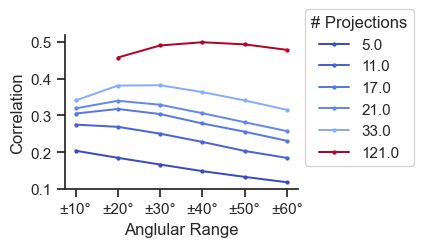

In [76]:
#Correlation plot examining angular range
thickness = '750nm'
#max_ang = 60
#num_ang = 33
#num_angs = [121, 33, 21, 17]
theta_labels = ['±%s°' % ang for ang in max_angs]

mag = '3.3k'

if mag == '3.3k':
    my_df = all_fsc_3k
elif mag == '11k':
    my_df = all_fsc_11k

my_df = my_df[my_df['thickness']==thickness]
my_df = my_df[my_df['num_ang'].isin(num_angs)]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

my_df.dropna(subset=['correlation'], inplace=True)
g = sns.pointplot(my_df,x='max_ang', y='correlation', hue='num_ang', estimator='median',
            errorbar=None, native_scale=True, dodge = 0, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})
handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles,  title = '# Projections',
         bbox_to_anchor=(1, 0.1), loc=
         'lower left',ncol=1)
g.set_xlabel('Anglular Range')
g.set_xticks(max_angs)
g.set_xticklabels(theta_labels)
g.set_ylabel('Correlation')
sns.despine()
#plt.savefig(figs_dir + 'thetaRange_Corr_Numang_3D_'+thickness+'.png', bbox_inches = 'tight')

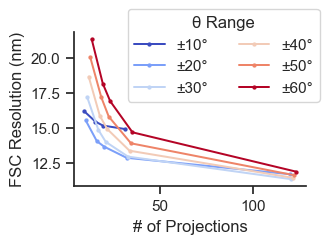

In [ ]:
thickness = '500nm'
max_ang = 60
num_ang = 33
num_angs = [121, 33, 21, 17, 11]
theta_labels = ['±%s°' % ang for ang in max_angs]

my_df = all_fsc
my_df = all_fsc[all_fsc['thickness']==thickness]
my_df = all_fsc[all_fsc['num_ang'].isin(num_angs)]

sns.set_theme(rc={'figure.figsize':(3,2),'lines.linewidth':0.8},style = 'ticks')

g = sns.pointplot(my_df,x='num_ang', y = 'fsc_resolution', hue='max_ang', estimator='median',
            #errorbar=('pi',50), 
            errorbar = None ,native_scale=True, dodge = 1, palette='coolwarm',
            log_scale = False,  markersize = 2, capsize = .2,
            err_kws={'linewidth':1})

handles, previous_labels = g.get_legend_handles_labels()
g.legend(handles=handles, labels=theta_labels, title = 'θ Range',
         bbox_to_anchor=(.2, .5), loc='lower left',ncol=2)
g.set_xlabel('# of Projections')
g.set_ylabel('FSC Resolution (nm)')
sns.despine()

plt.savefig(figs_dir + 'Numang_FSCres_thetaRange_3D.png', bbox_inches = 'tight')
